# Model Training: Logistic Regression, Random Forest, XGBoost
Train and compare three classifiers on the processed car ads data, then plot feature importances for the tree-based models.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
 )

try:
    from xgboost import XGBClassifier, XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

from src import config
from src.utils import ensure_directory

sns.set_theme(style='ticks')
fig_dir = config.FIGURES_DIR
ensure_directory(fig_dir)

processed_path = config.PROCESSED_DATA_PATH
print(f"Loading processed data from {processed_path}")
if not processed_path.exists():
    raise FileNotFoundError('Processed parquet not found. Run python3 -m src.pipeline first.')

df = pd.read_parquet(processed_path)
df.shape

Loading processed data from artifacts/processed/car_ads_processed.parquet


(207263, 58)

In [2]:
# Define target and feature sets
# Binary target: 1 if price above median, else 0
if 'price_pln' not in df.columns:
    raise KeyError('price_pln column missing; cannot define target.')

median_price = df['price_pln'].median()
df['price_above_median'] = (df['price_pln'] > median_price).astype(int)

numeric_features = config.NUMERIC_COLUMNS
categorical_features = config.CATEGORICAL_COLUMNS

missing_numeric = [c for c in numeric_features if c not in df.columns]
missing_categorical = [c for c in categorical_features if c not in df.columns]
if missing_numeric or missing_categorical:
    raise KeyError(f'Missing columns. Numeric: {missing_numeric}; Categorical: {missing_categorical}')

X = df[numeric_features + categorical_features].copy()
y = df['price_above_median']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)


Train size: (165810, 25) Test size: (41453, 25)


In [3]:
# Preprocessing: imputers + encoders + scalers
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)


In [4]:
def evaluate_classifier(model_name: str, model, X_test, y_test, y_pred, y_proba):
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
    }
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    else:
        metrics['roc_auc'] = np.nan
    return metrics

results = []
roc_curves = []


In [5]:
# Logistic Regression pipeline
log_reg = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, n_jobs=-1)),
    ]
)

log_reg.fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
log_proba = log_reg.predict_proba(X_test)[:, 1]

results.append(evaluate_classifier('log_reg', log_reg, X_test, y_test, log_pred, log_proba))

fpr, tpr, _ = roc_curve(y_test, log_proba)
roc_curves.append(('LogReg', fpr, tpr))

results[-1]

{'model': 'log_reg',
 'accuracy': 0.9368923841459001,
 'precision': 0.940632603406326,
 'recall': 0.9326449869728843,
 'f1': 0.9366217656749685,
 'roc_auc': 0.982997410620146}

In [6]:
# Random Forest pipeline
rf_clf = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            n_jobs=-1,
            random_state=42,
        )),
    ]
)

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_proba = rf_clf.predict_proba(X_test)[:, 1]

results.append(evaluate_classifier('random_forest', rf_clf, X_test, y_test, rf_pred, rf_proba))

fpr, tpr, _ = roc_curve(y_test, rf_proba)
roc_curves.append(('RandomForest', fpr, tpr))

results[-1]

{'model': 'random_forest',
 'accuracy': 0.95353774153861,
 'precision': 0.9533616282434648,
 'recall': 0.9537296149763582,
 'f1': 0.9535455861070912,
 'roc_auc': 0.991404845568683}

In [7]:
# XGBoost pipeline (optional)
if HAS_XGB:
    xgb_clf = Pipeline(
        steps=[
            ('preprocess', preprocessor),
            ('clf', XGBClassifier(
                n_estimators=500,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='binary:logistic',
                eval_metric='logloss',
                random_state=42,
                n_jobs=-1,
            )),
        ]
    )

    xgb_clf.fit(X_train, y_train)
    xgb_pred = xgb_clf.predict(X_test)
    xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]

    results.append(evaluate_classifier('xgboost', xgb_clf, X_test, y_test, xgb_pred, xgb_proba))

    fpr, tpr, _ = roc_curve(y_test, xgb_proba)
    roc_curves.append(('XGBoost', fpr, tpr))

    print('XGBoost metrics:', results[-1])
else:
    print('xgboost not installed; skipping XGBClassifier. Install via: pip install xgboost')

XGBoost metrics: {'model': 'xgboost', 'accuracy': 0.9530311437049188, 'precision': 0.9520050064988206, 'recall': 0.9541638521663611, 'f1': 0.9530832068242608, 'roc_auc': 0.9914508699201844}


In [8]:
# Aggregate results
results_df = pd.DataFrame(results)
results_df = results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
results_df.sort_values('f1', ascending=False)

,model,accuracy,precision,recall,f1,roc_auc
1,random_forest,0.953538,0.953362,0.953730,0.953546,0.991405
2,xgboost,0.953031,0.952005,0.954164,0.953083,0.991451
0,log_reg,0.936892,0.940633,0.932645,0.936622,0.982997


In [9]:
# Helper to get feature names after preprocessing
# Uses the fitted preprocessors attached to a trained pipeline

def get_feature_names(trained_pipeline):
    pre = trained_pipeline.named_steps['preprocess']
    cat_encoder = pre.named_transformers_['cat'].named_steps['encoder']
    num_features = numeric_features
    cat_features = list(cat_encoder.get_feature_names_out(categorical_features))
    return num_features + cat_features


def _get_model_step(pipeline):
    # Support both classifier ('clf') and regressor ('model') step keys
    if 'clf' in pipeline.named_steps:
        return pipeline.named_steps['clf']
    if 'model' in pipeline.named_steps:
        return pipeline.named_steps['model']
    raise KeyError('No model step found (expected "clf" or "model").')


def plot_importances(pipeline, title, save_name, top_n=20):
    feature_names = get_feature_names(pipeline)
    model_step = _get_model_step(pipeline)
    if hasattr(model_step, 'feature_importances_'):
        importances = model_step.feature_importances_
    else:
        raise AttributeError('Model does not expose feature_importances_.')

    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(fig_dir / save_name, bbox_inches='tight')
    plt.show()


In [10]:
# Helper to get feature names after preprocessing
# Uses the fitted preprocessors attached to a trained pipeline

def get_feature_names(trained_pipeline):
    pre = trained_pipeline.named_steps['preprocess']
    cat_encoder = pre.named_transformers_['cat'].named_steps['encoder']
    num_features = numeric_features
    cat_features = list(cat_encoder.get_feature_names_out(categorical_features))
    return num_features + cat_features


def plot_importances(model, title, save_name, top_n=20):
    feature_names = get_feature_names(model)
    if hasattr(model.named_steps['clf'], 'feature_importances_'):
        importances = model.named_steps['clf'].feature_importances_
    else:
        raise AttributeError('Model does not expose feature_importances_.')

    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(fig_dir / save_name, bbox_inches='tight')
    plt.show()


/tmp/ipykernel_1325297/4293284812.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')


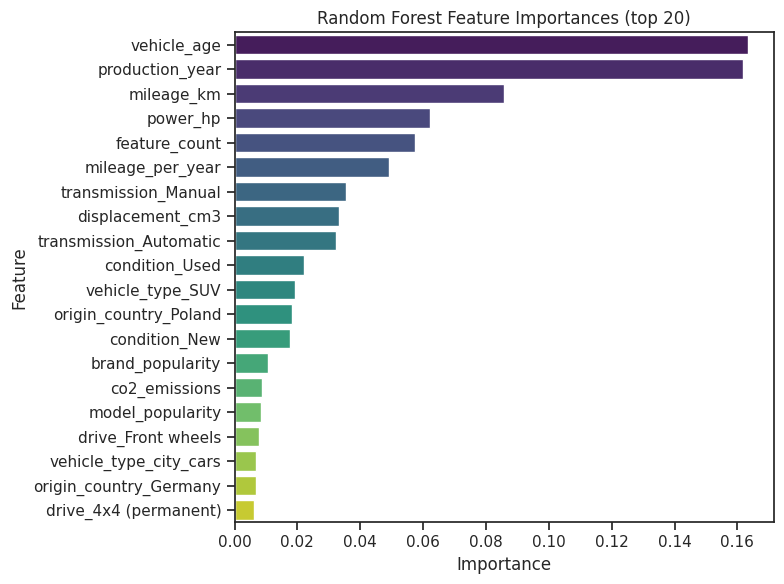

In [11]:
# Feature importances: Random Forest
plot_importances(
    rf_clf,
    title='Random Forest Feature Importances (top 20)',
    save_name='rf_feature_importances.png',
    top_n=20,
)


/tmp/ipykernel_1325297/4293284812.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')


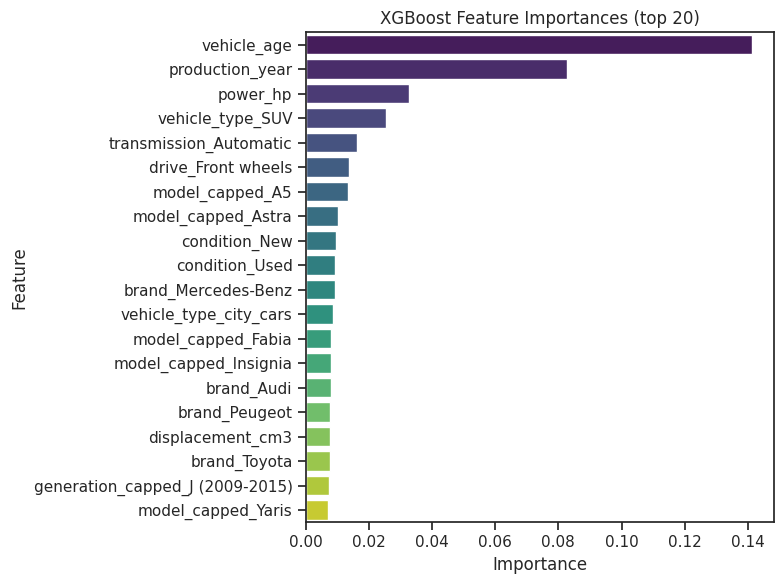

In [12]:
# Feature importances: XGBoost (if available)
if HAS_XGB:
    plot_importances(
        xgb_clf,
        title='XGBoost Feature Importances (top 20)',
        save_name='xgb_feature_importances.png',
        top_n=20,
    )
else:
    print('Skipping XGBoost importances; xgboost not installed.')

## Regression: predict price (MAE/MSE)
Train regressors to predict `price_pln` and evaluate on MAE/MSE/RMSE/R2; plot feature importances for tree models.

In [13]:
# Regression data split and preprocessing
if 'price_pln' not in df.columns:
    raise KeyError('price_pln column missing; cannot train regressors.')

reg_target = df['price_pln']
reg_features = df[numeric_features + categorical_features].copy()

reg_X_train, reg_X_test, reg_y_train, reg_y_test = train_test_split(
    reg_features, reg_target, test_size=0.2, random_state=42
)

reg_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
)
reg_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ]
)

reg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', reg_numeric, numeric_features),
        ('cat', reg_categorical, categorical_features),
    ]
)

print('Regression train size:', reg_X_train.shape, 'Test size:', reg_X_test.shape)

Regression train size: (165810, 25) Test size: (41453, 25)


In [23]:
def evaluate_regression(model_name: str, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    denom = np.where(np.abs(y_true) > 1e-6, np.abs(y_true), np.nan)
    mape = np.nanmean(np.abs((y_true - y_pred) / denom)) * 100
    return {
        'model': model_name,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mape_pct': mape,
    }

reg_results = []

In [24]:
# Linear Regression baseline
lin_reg = Pipeline(
    steps=[
        ('preprocess', reg_preprocessor),
        ('model', LinearRegression()),
    ]
)

lin_reg.fit(reg_X_train, reg_y_train)
lin_pred = lin_reg.predict(reg_X_test)
reg_results.append(evaluate_regression('linear_reg', reg_y_test, lin_pred))

reg_results[-1]

{'model': 'linear_reg',
 'mae': 20015.37790186244,
 'mse': 1067317354.8325591,
 'rmse': 32669.823305805607,
 'r2': 0.7783183775294376,
 'mape_pct': 71.51858777216405}

In [25]:
# Random Forest Regressor
rf_reg = Pipeline(
    steps=[
        ('preprocess', reg_preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=7,
            max_depth=None,
            n_jobs=-1,
            random_state=42,
        )),
    ]
)

rf_reg.fit(reg_X_train, reg_y_train)
rf_pred = rf_reg.predict(reg_X_test)
reg_results.append(evaluate_regression('random_forest_reg', reg_y_test, rf_pred))

reg_results[-1]

{'model': 'random_forest_reg',
 'mae': 7897.444704780312,
 'mse': 293512267.6764701,
 'rmse': 17132.19973256412,
 'r2': 0.9390375548388403,
 'mape_pct': 18.441365003970127}

In [26]:
# XGBoost Regressor (optional)
if HAS_XGB:
    xgb_reg = Pipeline(
        steps=[
            ('preprocess', reg_preprocessor),
            ('model', XGBRegressor(
                n_estimators=700,
                max_depth=14,
                objective='reg:squarederror',
                random_state=42,
                n_jobs=-1,
            )),
        ]
    )

    xgb_reg.fit(reg_X_train, reg_y_train)
    xgb_pred = xgb_reg.predict(reg_X_test)
    reg_results.append(evaluate_regression('xgboost_reg', reg_y_test, xgb_pred))

    print('XGBoost reg metrics:', reg_results[-1])
else:
    print('xgboost not installed; skipping XGBRegressor. Install via: pip install xgboost')

XGBoost reg metrics: {'model': 'xgboost_reg', 'mae': 7374.623163595552, 'mse': 260751508.51415247, 'rmse': 16147.801971604447, 'r2': 0.9458419586195783, 'mape_pct': 17.19994787120411}


In [21]:
# Summarize regression metrics
reg_results_df = pd.DataFrame(reg_results)
reg_results_df = reg_results_df[['model', 'mae', 'mse', 'rmse', 'r2', 'mape_pct']]
reg_results_df.sort_values('mae')

,model,mae,mse,rmse,r2,mape_pct
3,xgboost_reg,7143.500846,2.302531e+08,15174.093315,0.952176,17.369505
1,random_forest_reg,8130.890738,3.069968e+08,17521.323338,0.936237,18.946381
0,linear_reg,20015.377902,1.067317e+09,32669.823306,0.778318,71.518588
2,xgboost_reg,24311.756094,1.448026e+09,38052.930803,0.699245,104.489859


In [19]:
# Feature importances for regressors
plot_importances(
    rf_reg,
    title='Random Forest Regressor Feature Importances (top 20)',
    save_name='rf_reg_feature_importances.png',
    top_n=20,
)

if HAS_XGB:
    plot_importances(
        xgb_reg,
        title='XGBoost Regressor Feature Importances (top 20)',
        save_name='xgb_reg_feature_importances.png',
        top_n=20,
    )
else:
    print('Skipping XGBoost reg importances; xgboost not installed.')

KeyError: 'clf'

## XGBoost hyperparameter search (regression)
Randomized search over a small grid for XGBRegressor; reports best params and metrics on the test set.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

if not HAS_XGB:
    raise ImportError('xgboost not installed; install with pip install xgboost to run the search.')

xgb_search = Pipeline(
    steps=[
        ('preprocess', reg_preprocessor),
        ('model', XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

param_distributions = {
    'model__n_estimators': randint(200, 800),
    'model__max_depth': randint(4, 16),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': randint(1, 8),
}

search = RandomizedSearchCV(
    estimator=xgb_search,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

search.fit(reg_X_train, reg_y_train)

print('Best params:', search.best_params_)
print('Best CV MAE:', -search.best_score_)

best_xgb = search.best_estimator_
best_pred = best_xgb.predict(reg_X_test)
best_metrics = evaluate_regression('xgb_reg_search', reg_y_test, best_pred)
best_metrics

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'model__colsample_bytree': 0.7024273291045295, 'model__learning_rate': 0.01808671790768627, 'model__max_depth': 13, 'model__min_child_weight': 2, 'model__n_estimators': 660, 'model__subsample': 0.6806876809341584}
Best CV MAE: 7103.018091041266


{'model': 'xgb_reg_search',
 'mae': 6951.101324723063,
 'mse': 222589426.55910063,
 'rmse': 14919.431174113195,
 'r2': 0.9537682161720732,
 'mape_pct': 16.904984987389348}

In [32]:
# Persist tuned XGBoost regressor for Streamlit app
ensure_directory(config.MODEL_PATH.parent)
joblib.dump(best_xgb, config.MODEL_PATH)
print(f"Saved model to {config.MODEL_PATH}")

Saved model to artifacts/models/price_model.joblib
